Load the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import math
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [2]:
LOAD_FINETUNED_MODELS = True
ENABLE_BAYES = False
MAGNITUDES = [0.0, 1.0, 1.5, 2.0, 2.5, 5.0]
dummy_labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
                'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
target_labels = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
model_names = ['DenseNet121','DenseNet169','DenseNet201','VGG16','VGG19','Xception','InceptionResNetV2']

In [3]:
def apply_bayes_to_predictions(pred):
    bpred = np.copy(pred)
    bpred[...,5] = bpred[...,3] * bpred[...,5]
    bpred[...,6] = bpred[...,3] * bpred[...,6]
    bpred[...,7] = bpred[...,3] * bpred[...,7]
    bpred[...,4] = bpred[...,3] * bpred[...,4]
    bpred[...,8] = bpred[...,3] * bpred[...,8]
    bpred[...,2] = bpred[...,1] * bpred[...,2]
    return bpred

from scipy.stats import entropy

def apply_simple_mean(predictions, axis=None):
    return np.average(predictions, axis=axis)

def apply_entropy_weighted_mean(predictions, axis=None):
    entropies = entropy([predictions,1-predictions],base = 2)
    weights = 1-entropies
    return np.sum(predictions*weights, axis=axis)/np.sum(weights, axis=axis)

def apply_majority_voting(predictions, axis=None, threshold=0.5):
    binary_pred = predictions >= threshold
    binary_pred = binary_pred.astype(int)
    votes = binary_pred.sum(axis=axis)
    final_pred = votes >=4
    final_pred = final_pred.astype(int)
    return final_pred



In [4]:
predictions = np.load('./Predictions/v2/test_predictions_tta.npy') # Shape (samples, augmentations, magnitude, model, labels)
labels = np.load('./Predictions/v2/test_labels_tta.npy') # Shape (samples, augmentations, magnitude, model, labels)
tta_params = pd.read_csv('Predictions/v2/tta_params.csv', index_col=0) # Columns (Sample, Magnitude, Method, Param)
bayes_predictions = apply_bayes_to_predictions(predictions)

# Single Model Performances

## Method 1: (sample, aug, magnitude, model, labels) -> Aggr on aug -> (sample, magnitude, model, label) -> Aggr on Model -> (sample, magnitude, label) -> Evaluation

## TODO: Fix Entropies

In [6]:
def apply_two_step_aggregation(pred, gt):
    aggr_aug_preds = {'simple_mean': apply_simple_mean(pred, axis=1),
                      # 'weighted_mean': apply_entropy_weighted_mean(predictions, axis=1), # FIXME: Here some weights sum to zero. Why?
                      'voting': apply_majority_voting(pred, axis=1)}
    aggr_aug_labels = apply_simple_mean(gt, axis=1)

    aggr_mod_preds = {'simple_mean': {l: apply_simple_mean(p, axis=2) for l, p in aggr_aug_preds.items()},
                      'weighted_mean': {l: apply_entropy_weighted_mean(p, axis=2) for l, p in aggr_aug_preds.items()},
                      'voting': {l: apply_majority_voting(p, axis=2) for l, p in aggr_aug_preds.items()}
                     }
    aggr_mod_labels = apply_simple_mean(aggr_aug_labels, axis=2)
    return aggr_mod_preds, aggr_mod_labels

aggr_2step_mod_preds, aggr_2step_mod_labels = apply_two_step_aggregation(predictions, labels)
aggr_2step_mod_preds_bayes, aggr_2step_mod_labels_bayes = apply_two_step_aggregation(bayes_predictions, labels)

In [7]:
def get_auc_without_tta(preds, ground_truths):
    preds_no_tta = preds[:,:,0,:,:].mean(axis=1).transpose(1, 0, 2)
    gt_no_tta = ground_truths[:,:,0,:,:].mean(axis=1).transpose(1, 0, 2)
    results = pd.DataFrame()
    for m, (modname, model_preds, model_gt) in enumerate(zip(model_names, preds_no_tta, gt_no_tta)):
        for l, labname in enumerate(dummy_labels):
            fpr, tpr, thresholds = roc_curve(model_gt[:,l], model_preds[:,l])
            score = auc(fpr, tpr)
            results = results.append({'model': modname, 'label':labname, 'auc': score}, ignore_index=True)
    return results

def get_best_singlemodel_score(singlemodel_results):
    best_singlemodel_scores = pd.DataFrame()
    for lab, df in singlemodel_results.groupby(['label']):
        best_singlemodel_scores = best_singlemodel_scores.append({'label':lab, 'auc': df.max()['auc'], 'model':df.set_index('model')['auc'].idxmax(axis='auc')}, ignore_index=True)
    return best_singlemodel_scores


single_models_results = get_auc_without_tta(predictions, labels)
single_models_results_bayes = get_auc_without_tta(bayes_predictions, labels)

best_singlemodel_results = get_best_singlemodel_score(single_models_results)
best_singlemodel_results_toshow = best_singlemodel_results.loc[best_singlemodel_results['label'].isin(target_labels)]

best_singlemodel_results_bayes = get_best_singlemodel_score(single_models_results_bayes)
best_singlemodel_results_bayes_toshow = best_singlemodel_results_bayes.loc[best_singlemodel_results_bayes['label'].isin(target_labels)]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [8]:
single_models_results.loc[single_models_results['label'].isin(target_labels)].to_csv('single_models_results_v2.csv')
single_models_results_bayes.loc[single_models_results_bayes['label'].isin(target_labels)].to_csv('single_models_results_bayes_v2.csv')

In [9]:
def get_2step_aurocs(predictions_dict, labels):
    results = pd.DataFrame()
    for step2_aggr, step1_preds in predictions_dict.items():
        for step1_aggr, preds in step1_preds.items():
            preds = preds.transpose((1, 0, 2))
            for m, (magn, magnitude_preds) in enumerate(zip(MAGNITUDES, preds)):
                for l, labname in enumerate(dummy_labels):
                    try:
                        fpr, tpr, thresholds = roc_curve(labels[:,m,l], magnitude_preds[:,l])
                        score = auc(fpr, tpr)
                        results = results.append({'step1_aggr':step1_aggr, 'step2_aggr': step2_aggr, 'magnitude': magn, 'label': labname,  'auc':score}, ignore_index=True)
                    except:
                        print("Error in label {}".format(labname))
    return results

two_step_results = get_2step_aurocs(aggr_2step_mod_preds, aggr_2step_mod_labels)
two_step_results_toshow = two_step_results[two_step_results['label'].isin(target_labels)]

two_step_results_bayes = get_2step_aurocs(aggr_2step_mod_preds_bayes, aggr_2step_mod_labels_bayes)
two_step_results_bayes_toshow = two_step_results[two_step_results['label'].isin(target_labels)]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


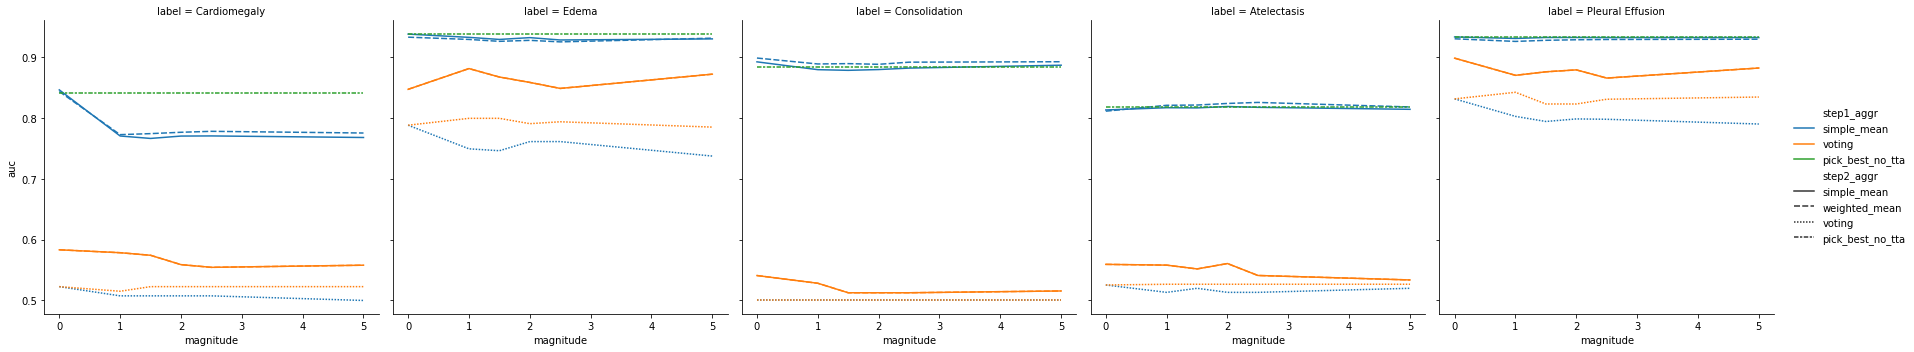

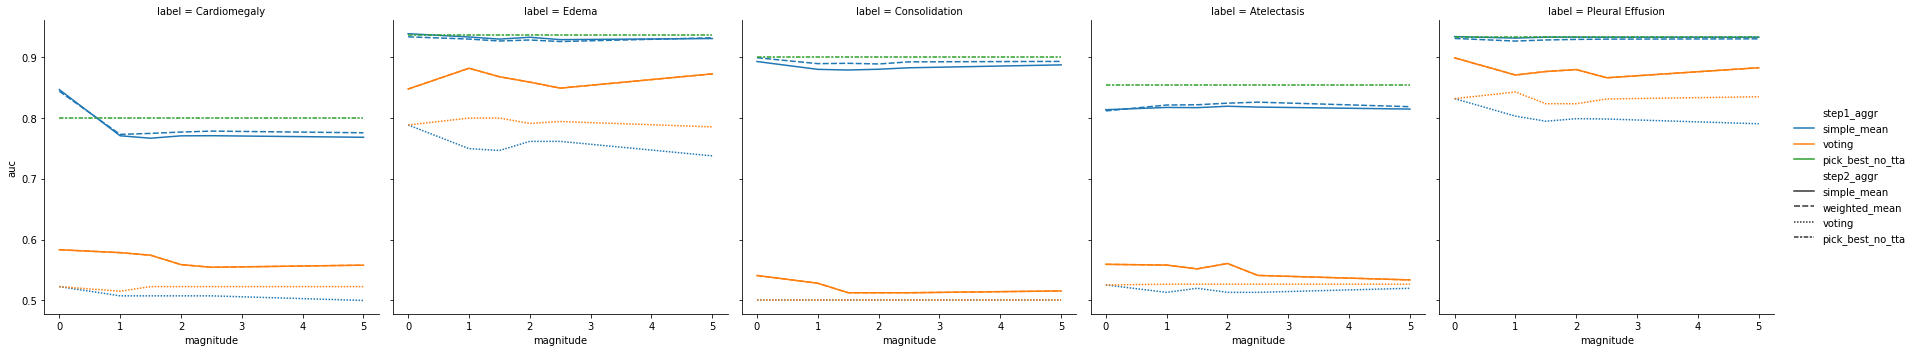

In [10]:
def plot_2step_graphs(twostep_results, pickbest_results):
    # Merging the pickbest strategy and the twostep dataframe to show a baseline
    to_show = pd.DataFrame()
    to_show = to_show.append(twostep_results, ignore_index=True)
    for mag in twostep_results['magnitude'].unique():
        new_x_point = pd.DataFrame(pickbest_results)
        new_x_point = new_x_point.drop(columns=['model']) # We don't care plotting the best model
        new_x_point['magnitude'] = mag
        new_x_point['step1_aggr'] = 'pick_best_no_tta'
        new_x_point['step2_aggr'] = 'pick_best_no_tta'        
        to_show = to_show.append(new_x_point, ignore_index=True)
    plotgrid = sns.relplot(data=to_show, x='magnitude', y='auc', col='label', hue='step1_aggr', style='step2_aggr', kind='line')
    
plot_2step_graphs(two_step_results_toshow, best_singlemodel_results_toshow)
plot_2step_graphs(two_step_results_bayes_toshow, best_singlemodel_results_bayes_toshow)

## Method 2: (sample, aug, magnitude, model, labels) -> Reshape -> (sample, magnitude, model*aug, label) -> Aggr on Aug*Model -> (sample, magnitude, label) -> Evaluation

In [11]:
def apply_one_step_aggregation(pred, gt):
    resh_aug_preds = pred.transpose(0, 2, 1, 3, 4)
    newshape = [resh_aug_preds.shape[0],resh_aug_preds.shape[1], resh_aug_preds.shape[2]*resh_aug_preds.shape[3], resh_aug_preds.shape[4]]
    resh_aug_preds = resh_aug_preds.reshape(newshape)
    
    resh_aug_labels = gt.transpose(0, 2, 1, 3, 4)
    resh_aug_labels = resh_aug_labels.reshape(newshape)
        
    aggr_mod_preds = {'simple_mean': apply_simple_mean(resh_aug_preds, axis=2),
                      'weighted_mean': apply_entropy_weighted_mean(resh_aug_preds, axis=2),
                      'voting': apply_majority_voting(resh_aug_preds, axis=2)
                     }
    aggr_mod_labels = apply_simple_mean(resh_aug_labels, axis=2)
    return aggr_mod_preds, aggr_mod_labels

aggr_1step_mod_preds, aggr_1step_mod_labels = apply_one_step_aggregation(predictions, labels)
aggr_1step_mod_preds_bayes, aggr_1step_mod_labels_bayes = apply_one_step_aggregation(bayes_predictions, labels)

In [12]:
def get_1step_aurocs(predictions_dict, labels):
    results = pd.DataFrame()
    for step2_aggr, preds in predictions_dict.items():
            preds = preds.transpose((1, 0, 2))
            for m, (magn, magnitude_preds) in enumerate(zip(MAGNITUDES, preds)):
                for l, labname in enumerate(dummy_labels):
                    try:
                        fpr, tpr, thresholds = roc_curve(labels[:,m,l], magnitude_preds[:,l])
                        score = auc(fpr, tpr)
                        results = results.append({'step2_aggr': step2_aggr, 'magnitude': magn, 'label': labname,  'auc':score}, ignore_index=True)
                    except:
                        print("Error in label {}".format(labname))
    return results

one_step_results = get_1step_aurocs(aggr_1step_mod_preds, aggr_1step_mod_labels)
one_step_results_toshow = one_step_results[one_step_results['label'].isin(target_labels)]

one_step_results_bayes = get_1step_aurocs(aggr_1step_mod_preds_bayes, aggr_1step_mod_labels_bayes)
one_step_results_bayes_toshow = one_step_results[one_step_results['label'].isin(target_labels)]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


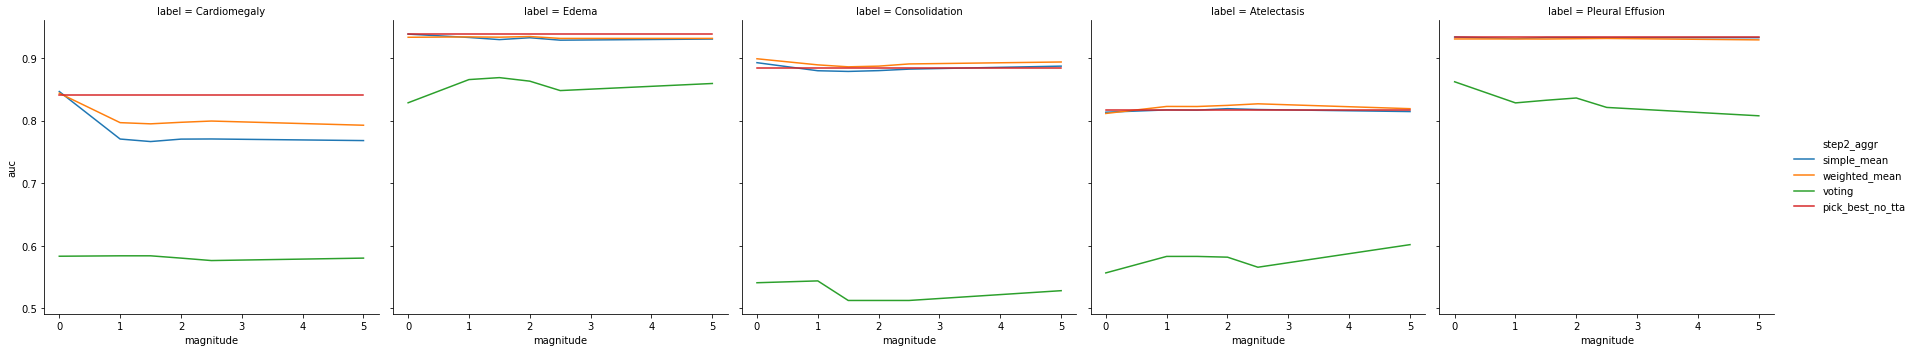

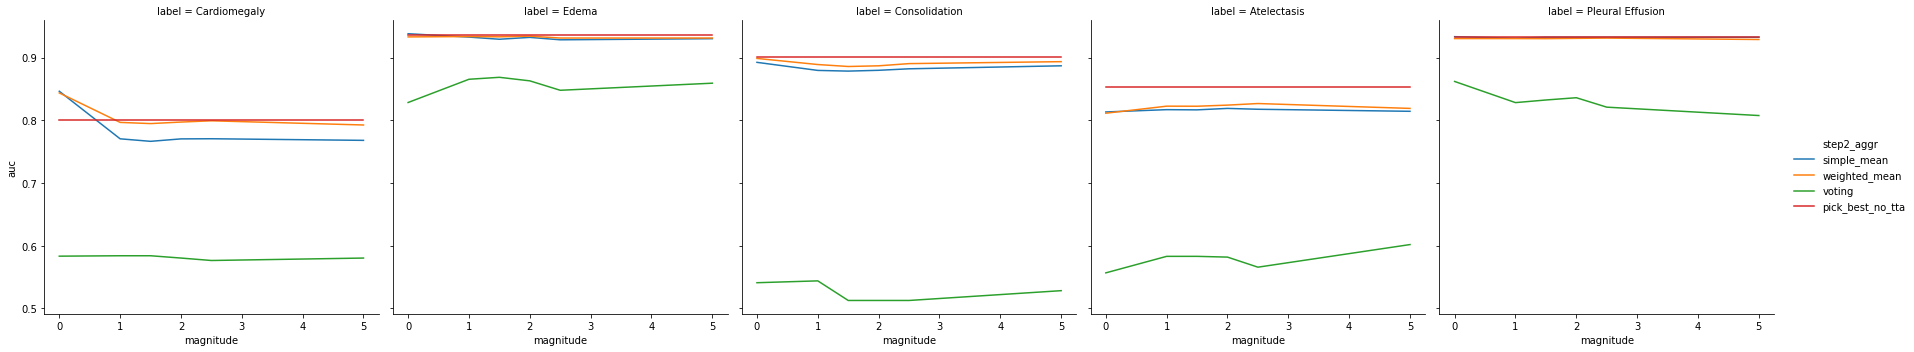

In [13]:
def plot_2step_graphs(twostep_results, pickbest_results):
    # Merging the pickbest strategy and the onestep dataframe to show a baseline
    to_show = pd.DataFrame()
    to_show = to_show.append(twostep_results, ignore_index=True)
    for mag in twostep_results['magnitude'].unique():
        new_x_point = pd.DataFrame(pickbest_results)
        new_x_point = new_x_point.drop(columns=['model']) # We don't care plotting the best model
        new_x_point['magnitude'] = mag
        new_x_point['step2_aggr'] = 'pick_best_no_tta'        
        to_show = to_show.append(new_x_point, ignore_index=True)
    plotgrid = sns.relplot(data=to_show, x='magnitude', y='auc', col='label', hue='step2_aggr', kind='line')
    
plot_2step_graphs(one_step_results_toshow, best_singlemodel_results_toshow)
plot_2step_graphs(one_step_results_bayes_toshow, best_singlemodel_results_bayes_toshow)

In [14]:
results_to_save = pd.DataFrame()
temp = pd.DataFrame(one_step_results_toshow)
temp['aug_steps'] = 'one'
temp['bayes'] = 'no'
results_to_save = results_to_save.append(temp, ignore_index=True)
temp = pd.DataFrame(one_step_results_bayes_toshow)
temp['aug_steps'] = 'one'
temp['bayes'] = 'yes'
results_to_save = results_to_save.append(temp, ignore_index=True)
temp = pd.DataFrame(two_step_results_toshow)
temp['aug_steps'] = 'two'
temp['bayes'] = 'no'
results_to_save = results_to_save.append(temp, ignore_index=True)
temp = pd.DataFrame(two_step_results_bayes_toshow)
temp['aug_steps'] = 'two'
temp['bayes'] = 'yes'
results_to_save = results_to_save.append(temp, ignore_index=True)
temp = pd.DataFrame(best_singlemodel_results_toshow)
temp['bayes'] = 'no'
temp['aug_steps'] = 'pick_best_no_tta'
results_to_save = results_to_save.append(temp, ignore_index=True)
temp = pd.DataFrame(best_singlemodel_results_bayes_toshow)
temp['bayes'] = 'yes'
temp['aug_steps'] = 'pick_best_no_tta'
results_to_save = results_to_save.append(temp, ignore_index=True)


In [ ]:

results_to_save.to_csv('results/v2/aggregations.csv')

In [15]:
results_to_save

,auc,label,magnitude,step2_aggr,aug_steps,bayes,step1_aggr,model
0,0.846368,Cardiomegaly,0.0,simple_mean,one,no,NaN,NaN
1,0.938095,Edema,0.0,simple_mean,one,no,NaN,NaN
2,0.892463,Consolidation,0.0,simple_mean,one,no,NaN,NaN
3,0.813333,Atelectasis,0.0,simple_mean,one,no,NaN,NaN
4,0.933424,Pleural Effusion,0.0,simple_mean,one,no,NaN,NaN
...,...,...,...,...,...,...,...,...
545,0.853753,Atelectasis,NaN,NaN,pick_best_no_tta,yes,NaN,DenseNet121
546,0.799911,Cardiomegaly,NaN,NaN,pick_best_no_tta,yes,NaN,DenseNet121
547,0.900368,Consolidation,NaN,NaN,pick_best_no_tta,yes,NaN,VGG19
548,0.936310,Edema,NaN,NaN,pick_best_no_tta,yes,NaN,DenseNet169


In [30]:
temp = two_step_results_bayes_toshow.loc[(two_step_results_bayes_toshow['step2_aggr']=='simple_mean') & (two_step_results_bayes_toshow['step1_aggr']=='simple_mean')]


In [34]:
temp.pivot(index='label', columns=['magnitude'], values=['auc'])

KeyError: 'Level magnitude not found'

In [ ]:
# Merging the (sample, augmentation) dimensions
new_shape = (predictions.shape[0]*predictions.shape[1], predictions.shape[2], predictions.shape[3], predictions.shape[4])
predictions_merged = predictions.reshape(new_shape)
predictions_bayes_merged = bayes_predictions.reshape(new_shape)
labels_merged = labels.reshape(new_shape)

In [42]:
def single_model_performance(predictions, ground_truth, tta_params=tta_params):
    '''
    predictions: Array-Like of shape (Samples, Augmentations, Magnitudes, Models, Labels)
    ground_truth: Array-Like of shape (Samples, Augmentations, Magnitudes, Models, Labels)
    '''
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    # transposing to keep (samples, labels) as last dimensions
    predictions = predictions.transpose(1, 2, 3, 0, 4)
    ground_truth = ground_truth.transpose(1, 2, 3, 0, 4)
    #arams_transposed = tta_params.set_index(['method', 'magnitude'])
    
    titles = model_names
    #fig, c_ax = plt.subplots(2,3, figsize = (15, 10))
    #ig = plt.figure(figsize=(25,14))
    
    results = pd.DataFrame()

    for id_augm, (pred_augm, gt_augm) in enumerate(zip(predictions, ground_truth)):
        for id_magn, (pred_magn, gt_magn) in enumerate(zip(pred_augm, gt_augm)):
            magnitude = tta_params['magnitude'].unique()[id_magn]
            method = tta_params.loc[(tta_params['sample']==0) & (tta_params['magnitude']==magnitude)]['method'].iloc[id_augm]
            for id_model, (pred_model, gt_model) in enumerate(zip(pred_magn, gt_magn)):
                model = model_names[id_model]
                actual_param_variance = tta_params.loc[(tta_params['method']==method) & (tta_params['magnitude']==magnitude)]['param'].var()
                for id_label, label in enumerate(dummy_labels):
                    fpr, tpr, thresholds = roc_curve(gt_model[:,id_label], pred_model[:,id_label])
                    score = auc(fpr, tpr)
                    results = results.append({'method': method, 'magnitude': magnitude, 'model':model, 'param_var':actual_param_variance, 'label': label, 'single_model_auc':score}, ignore_index=True)
    return results

#test_res = plot_single_model_performance(test_predictions), test_Y.pivot(index='Model', columns='Label').to_csv('results/single_model.csv')
#tta_res = plot_single_model_performance(tta_prediction_means, test_Y).pivot(index='Model', columns='Label').to_csv('results/single_model_tta_norm.csv')
#tta_res = plot_single_model_performance(tta_predictions, test_Y_tta).pivot(index='Model', columns='Label').to_csv('results/single_model_tta_nomean.csv')
#test_res_nobayes = plot_single_model_performance(test_predictions,test_Y).pivot(index='Model', columns='Label').to_csv('results/single_model_nobayes.csv')
#tta_res_nobayes = plot_single_model_performance(tta_prediction_means,test_Y).pivot(index='Model', columns='Label').to_csv('results/single_model_tta_nobayes.csv')
perf_singlemodel_v2_nocond = single_model_performance(predictions, labels, tta_params)
perf_singlemodel_v2_nocond['bayes'] = 'no_bayes'

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [43]:
perf_singlemodel_v2_bayes = single_model_performance(bayes_predictions, labels, tta_params)
perf_singlemodel_v2_bayes['bayes'] = 'bayes'

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


## Single Model Performances with and without Bayes

In [ ]:
data_to_show = pd.DataFrame()
data_to_show = data_to_show.append(perf_singlemodel_v2_nocond, ignore_index=True)
data_to_show = data_to_show.append(perf_singlemodel_v2_bayes, ignore_index=True)
data_to_show = data_to_show[data_to_show['label'].isin(target_labels)]
p = sns.relplot(data=data_to_show, x='magnitude', y='single_model_auc', col='model', row='label', kind='line', hue='bayes')
# Results have variance due to the grouping in aggregation method

In [46]:
# Single model performance (merged)
def model_predictions_merged(model_predictions, ground_truth, magnitude_values):
    '''
    model_predictions: array-like of shape (samples, magnitude, models, labels)
    ground_truth: array-like of shape (samples, magnitude, models, labels)
    magnitude_values: list of magnitude values, must have the same length of the 2nd axis of predictions and gt
    '''
    
    results = pd.DataFrame()
    model_predictions = model_predictions.transpose(1, 2, 0, 3)
    ground_truth = ground_truth.transpose(1, 2, 0, 3)
    
    for magvalue, pred_magn, gt_magn in zip(magnitude_values, model_predictions, ground_truth):
        for model, modpred, modgt in zip(model_names, pred_magn, gt_magn):
            for id_label, label in enumerate(dummy_labels):
                fpr, tpr, thresholds = roc_curve(modgt[:,id_label], modpred[:,id_label])
                score = auc(fpr, tpr)
                results = results.append({'magnitude': magvalue, 'model':model, 'label': label, 'score':score}, ignore_index=True)
    return results

perf_singlemodel_merged_nobayes = model_predictions_merged(predictions_merged, labels_merged, tta_params['magnitude'].unique())
perf_singlemodel_merged_bayes = model_predictions_merged(predictions_bayes_merged, labels_merged, tta_params['magnitude'].unique())

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [47]:
perf_singlemodel_merged_nobayes = perf_singlemodel_merged_nobayes[perf_singlemodel_merged_nobayes['label'].isin(target_labels)]

In [84]:
temp1 = perf_singlemodel_merged_nobayes
temp2 = perf_singlemodel_merged_bayes
temp1['bayes'] = 'no_bayes'
temp2['bayes'] = 'bayes'
tosave = pd.concat([temp1, temp2])
tosave = tosave[tosave['label'].isin(target_labels)]
tosave.to_csv('single_models_v2.csv')

In [29]:
tosave

NameError: name 'tosave' is not defined